# Data cleaning


In [1]:
# Initial imports
import pandas as pd
import numpy as np
from path import Path
# Graphing libraries
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
# Clustering class K-Means
from sklearn.cluster import KMeans

%matplotlib inline

In [9]:
# Loading data 
data = pd.read_csv(Path('Resources/oecd_data.csv'))

In [10]:
data.head()

,Country,"Current expenditure, % GDP","Curr exp, per capita US$PPP","GovtCompIns, % curr exp","GovtCompIns, per capita US$PPP","OOP payments, % curr exp","OOP payments, per capita US$PPP",Physicians,Nurses,Medical graduates,...,Hospital beds,Psychiatric care beds,MRI,CT scanners,Doctor constulations,Inpatient care discharges,"ALOS, inpatient care",LE Total population at birth,LE Females at 65,LE Males at 65
0,Australia,9.252,5005.316,69.267,3467.036,18.338,837.281,3.68,11.68,15.45,...,3.84,0.42,14.15,64.35,7.7,18050.1,5.6,82.6,19.7,22.3
1,Austria,10.330,5395.106,74.745,4032.585,25.255,1362.521,5.18,6.85,14.41,...,7.37,0.61,22.96,28.64,6.5,24925.6,8.3,81.7,18.5,21.5
2,Belgium,10.372,4943.537,77.271,3819.944,17.635,852.155,3.08,10.96,14.80,...,5.66,1.36,11.60,23.03,7.0,16528.4,7.3,81.6,18.5,21.9
3,Canada,10.741,4974.330,69.677,3465.984,15.063,749.264,2.65,9.96,7.66,...,2.52,0.34,9.97,15.28,6.8,8376.8,7.4,82.0,19.3,22.1
4,Chile,8.911,2181.726,58.307,1272.100,35.131,766.466,2.45,2.72,8.69,...,2.11,0.10,12.30,24.27,3.6,8910.2,6.0,80.2,17.8,21.5


In [3]:
# Fetch country names for later use
names = data['Country']
data.set_index('Country', inplace=True)

# Extract features
MedicalStaff = data['Nurses']
Capacity = data['Hospital beds']
Activity = data['Doctor constulations']
Spending = np.array(data['GovtCompIns, per capita US$PPP']).reshape(-1, 1)

# Features DF 
features = pd.concat([MedicalStaff, Capacity, Activity], axis=1, join='inner')

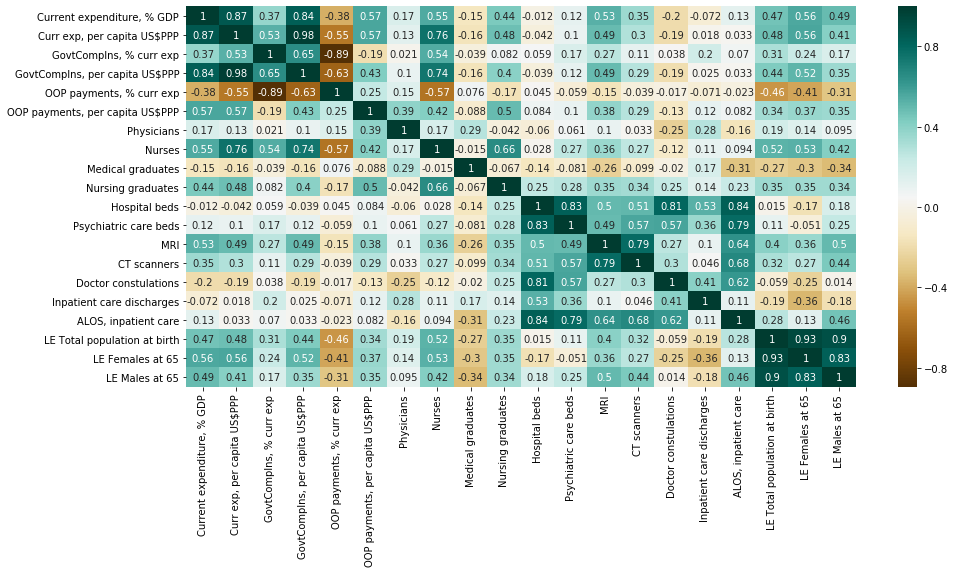

In [4]:
# Finding the relations between the variables
corr = data.corr()

# Plot heatmap with seaborn
plt.figure(figsize=(15,7))
sns.heatmap(corr,cmap='BrBG',annot=True)

# Data pre-processing

In [5]:
# Create df to apply tranformations
features_df = features.copy()

In [6]:
# Normalize observational weight variable with MinMax class
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(.1, 1))

# Fit and scale
weight_scaled = scaler.fit_transform(Spending)

In [7]:
# Normalize feature variables with StandardScaler class
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Fit and scale 
features_scaled = ss.fit_transform(features_df)

In [8]:
# Define X for data and Y for observational weight
X = np.array(features_scaled.astype(float))

# Convert to 1d array
Y = (np.array(weight_scaled.astype(float))).flatten()



# Clustering using K-Means

In [9]:
# Initializing models with different number of clusters 
model_5 = KMeans(
    n_clusters=5, 
    random_state=5
)

In [10]:
# Fitting model with scaled features
model_5.fit(features_scaled)

# Get predictions 
predictions = model_5.predict(features_scaled)

In [11]:
# Add new clusters  column to DF 
features['Unweighted cluster'] = model_5.labels_

In [12]:
# Unweighted centroids
model_5.cluster_centers_

array([[ 1.82451059, -0.40320304, -0.67025981],
       [-1.03825029, -0.54234356, -0.41428959],
       [-0.33337805,  0.86200908,  0.81789961],
       [ 0.52567731, -0.39214747, -0.33319274],
       [ 0.0741147 ,  3.12514873,  2.75562016]])

In [13]:
model_5.fit(X, sample_weight=Y)

predictions2 = model_5.predict(X, sample_weight=Y)

In [14]:
# Add new clusters PCA column to DF 
features['Weighted cluster'] = model_5.labels_

In [15]:
# Weighted centroids
model_5.cluster_centers_

array([[ 0.06471592,  0.80532369,  0.51062727],
       [ 0.50941657, -0.6161101 , -0.4835756 ],
       [-1.0192997 , -0.49722574, -0.33166522],
       [ 0.25575526,  3.17355711,  2.53377898],
       [ 1.8970686 , -0.37956872, -0.68657599]])

In [17]:
# Add spending health expenditure column
# features.insert(3, "Health expenditure", Spending)

# Save results to pickle 
features.to_pickle("oecdclusters")

In [3]:
# Create pivot table
table = features.reset_index()

# Display entire DataFrame
table.hvplot.table(
    columns=["Country", 'Nurses', 'Hospital beds', 
             'Doctor constulations', 'Health expenditure', 
             'Unweighted cluster', "Weighted cluster"], 
    width=800
)

:Table   [Country,Nurses,Hospital beds,Doctor constulations,Health expenditure,Unweighted cluster,Weighted cluster]

In [4]:
# Look at countries cluster migration 
features.loc[features['Unweighted cluster'] == 1]

,Nurses,Hospital beds,Doctor constulations,Health expenditure,Unweighted cluster,Weighted cluster
Country,,,,,,
Chile,2.72,2.11,3.6,1272.100,1,2
Estonia,6.19,4.69,5.9,1678.881,1,2
Greece,3.31,4.21,4.0,1348.837,1,2
Israel,5.08,3.02,6.1,1773.014,1,2
Italy,5.80,3.18,6.8,2544.577,1,2
Latvia,4.57,5.57,6.1,1003.741,1,2
Mexico,2.90,1.38,2.8,585.802,1,2
Portugal,6.70,3.39,4.1,1901.778,1,2
Spain,5.74,2.97,7.3,2341.375,1,2


# Visualization

## 3D-Scatter

In [5]:
# Create a 3D-Scatter with fundamental resources presented as axes
scatter3d = px.scatter_3d(
        table,
        x="Nurses",
        y="Hospital beds",
        z="Doctor constulations",
        width=600,
        color='Unweighted cluster',
        hover_name = 'Country'
    )
scatter3d.show()

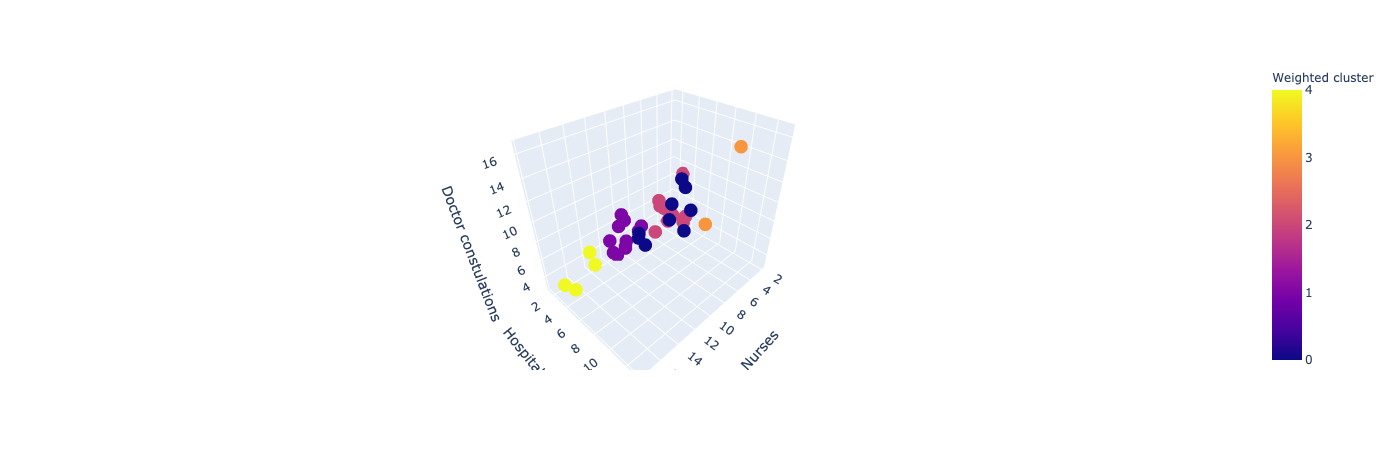

In [11]:
# Create a 3D-Scatter with fundamental resources presented as axes
# and adding healthcare exependiture as an observational weight
scatter3d = px.scatter_3d(
        table,
        x="Nurses",
        y="Hospital beds",
        z="Doctor constulations",
        width=600,
        color='Weighted cluster',
        hover_name = 'Country'
    )
scatter3d.show()